# Descripción del problema

La compañía de seguros Sure Tomorrow quiere resolver varias tareas con la ayuda de machine learning y te pide que evalúes esa posibilidad.

- __Tarea 1__: encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
<br>

- __Tarea 2__: predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
<br>

- __Tarea 3__: predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
<br>

- __Tarea 4__: proteger los datos personales de los clientes sin afectar al modelo del ejercicio anterior. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas. Esto se denomina enmascaramiento u ofuscación de datos. Pero los datos deben protegerse de tal manera que no se vea afectada la calidad de los modelos de machine learning. No es necesario elegir el mejor modelo, basta con demostrar que el algoritmo funciona correctamente.

# Preprocesamiento y exploración de datos

## Inicialización

In [3]:
# Instalar la version mas reciente de la biblioteca scikit-learn
!pip install scikit-learn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 68.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 60.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 36.4 MB/s eta 0:00:0000:0100:01


In [4]:
#Importar librerias para el proyecto
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Carga de datos

Carga los datos y haz una revisión básica para comprobar que no hay problemas obvios.

In [5]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente con su estilo.

In [6]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [7]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1983,0,26.0,42200.0,0,0
4408,1,24.0,48000.0,0,0
3614,1,24.0,32700.0,1,0
4586,0,45.0,49500.0,0,1
1581,0,24.0,57400.0,1,0
2153,0,35.0,39300.0,1,0
3144,1,41.0,43500.0,1,0
4635,1,24.0,30000.0,1,0
4931,0,21.0,48300.0,2,0
4054,0,42.0,56300.0,1,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [9]:
# puede que queramos cambiar el tipo de edad (de float a int) aunque esto no es crucial

# escribe tu conversión aquí si lo deseas:
df['age'] = df['age'].astype('int') 

In [10]:
# comprueba que la conversión se haya realizado con éxito

df['age'].dtype

dtype('int64')

In [11]:
# ahora echa un vistazo a las estadísticas descriptivas de los datos.# ¿Se ve todo bien?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Observamos que no existen valores faltantes para todas las columnas. Por otro lado los ingresos presentan una alta desviación estandar lo que indica su alta dispersión, por lo que sería interesante graficar su distribución en boxplots.

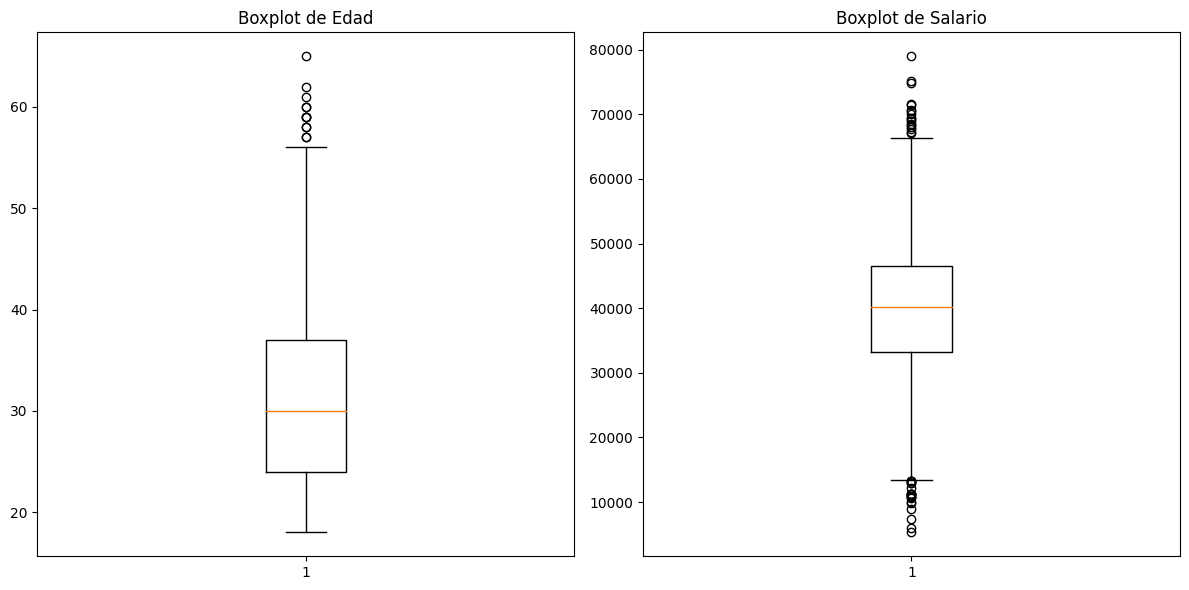

In [12]:
import matplotlib.pyplot as plt

# Visualización de posibles valores extremos en las columnas Age y Salary
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot(df['age'])
plt.title('Boxplot de Edad')

plt.subplot(1, 2, 2)
plt.boxplot(df['income'])
plt.title('Boxplot de Salario')

plt.tight_layout()
plt.show()

* __Edad__: No se observan valores extremos significativos, lo que sugiere que las edades están dentro de un rango esperado y no hay outliers evidentes.
<br>

* __Salario__: Se pueden observar algunos valores que podrían considerarse extremos en el lado superior del boxplot, lo que indica la presencia de personas con salarios más altos que la mayoría.

Estos valores extremos en salario pueden ser revisados más adelante, pero a primera vista, no parecen ser lo suficientemente extremos como para justificar una eliminación sin más análisis.

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

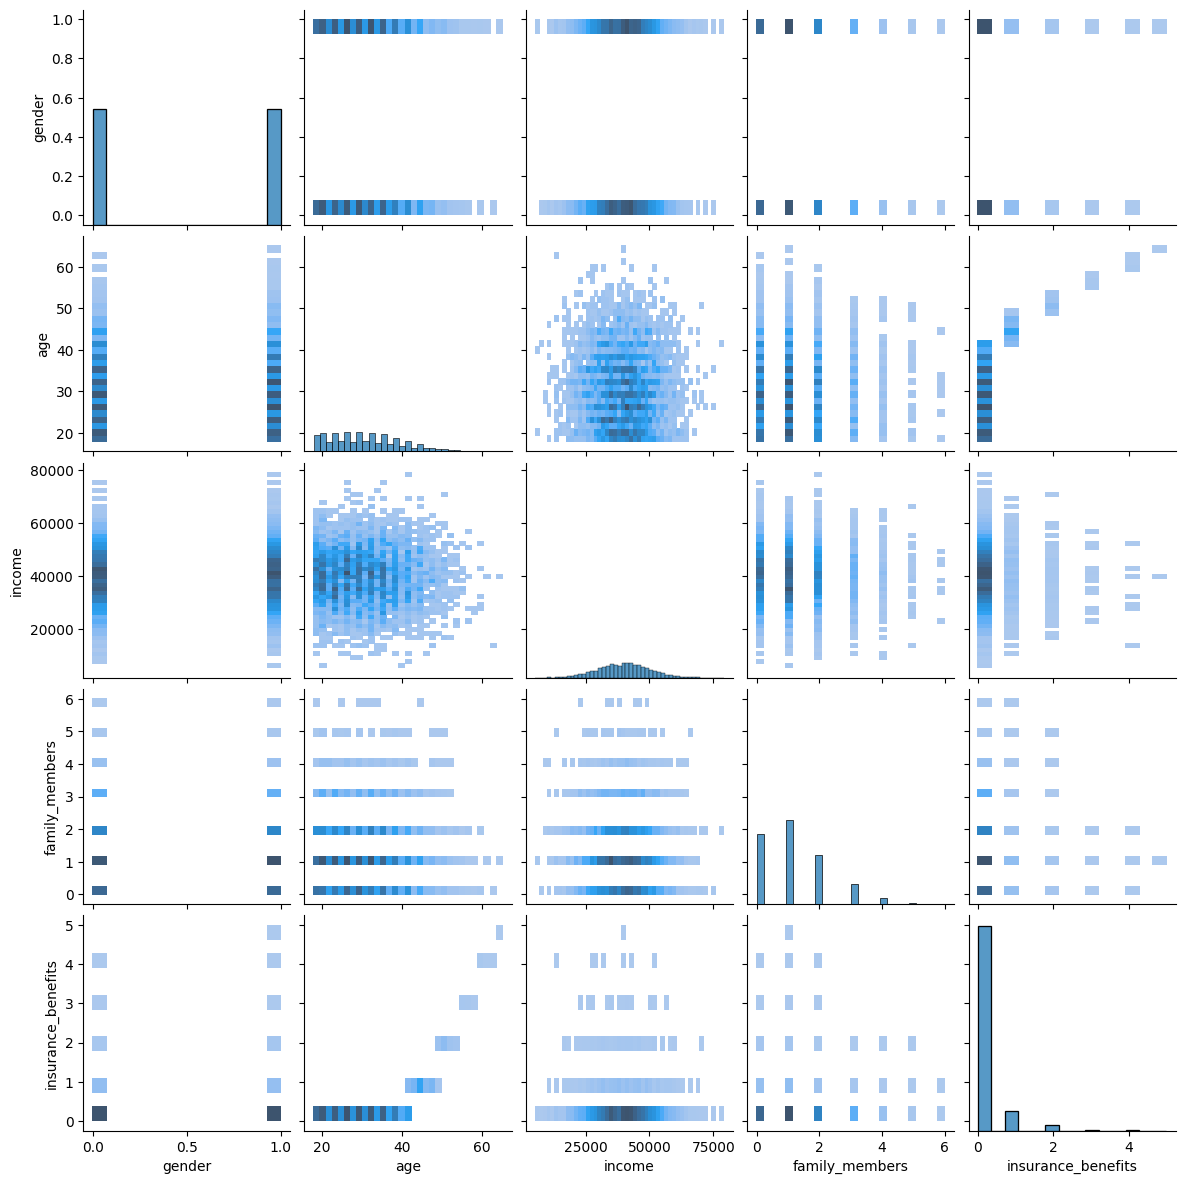

In [13]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

De acuerdo, es un poco complicado detectar grupos obvios (clústeres) ya que es difícil combinar diversas variables simultáneamente (para analizar distribuciones multivariadas). Ahí es donde LA y ML pueden ser bastante útiles.

# Tarea 1. Clientes similares

En el lenguaje de ML, es necesario desarrollar un procedimiento que devuelva los k vecinos más cercanos (objetos) para un objeto dado basándose en la distancia entre los objetos.
Es posible que quieras revisar las siguientes lecciones (capítulo -> lección)- Distancia entre vectores -> Distancia euclidiana
- Distancia entre vectores -> Distancia Manhattan

Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribe una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. A la hora de realizar esta tarea no debe tenerse en cuenta el número de prestaciones de seguro recibidas.
Puedes utilizar una implementación ya existente del algoritmo kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) o tu propia implementación.
Pruébalo para cuatro combinaciones de dos casos- Escalado
  - los datos no están escalados
  - los datos se escalan con el escalador [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
- Métricas de distancia
  - Euclidiana
  - Manhattan

Responde a estas preguntas:- ¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?- ¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [15]:
from sklearn.neighbors import NearestNeighbors

def get_knn(df, n, k, metric):
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar
    :param n: número de objetos para los que se buscan los vecinos más cercanos
    :param k: número de vecinos más cercanos a devolver
    :param metric: nombre de la métrica de distancia
    """
    
    # Inicialización del modelo kNN
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric)
    nbrs.fit(df[feature_names])
    
    # Encontrar los vecinos más cercanos
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], return_distance=True)
    
    # Crear un DataFrame con los vecinos más cercanos y sus distancias
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [16]:
from sklearn.preprocessing import MaxAbsScaler

feature_names = ['gender', 'age', 'income', 'family_members']

# Escalar datos usando MaxAbsScaler
transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [17]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2128,1.0,0.692308,0.512658,0.333333,1
1175,0.0,0.646154,0.496203,0.000000,1
2852,0.0,0.523077,0.444304,0.000000,0
2866,1.0,0.507692,0.703797,0.000000,0
4702,0.0,0.507692,0.426582,0.333333,0


Ahora, vamos a obtener registros similares para uno determinado, para cada combinación

In [18]:
from sklearn.preprocessing import MaxAbsScaler

# Obtener registros similares para cada combinación

# Caso 1: Datos no escalados, métrica Euclidiana
knn_result_euclidean_unscaled = get_knn(df, 0, 5, 'euclidean')

# Caso 2: Datos escalados con MaxAbsScaler, métrica Euclidiana
knn_result_euclidean_scaled = get_knn(df_scaled, 0, 5, 'euclidean')

# Caso 3: Datos no escalados, métrica Manhattan
knn_result_manhattan_unscaled = get_knn(df, 0, 5, 'manhattan')

# Caso 4: Datos escalados con MaxAbsScaler, métrica Manhattan
knn_result_manhattan_scaled = get_knn(df_scaled, 0, 5, 'manhattan')

knn_result_euclidean_unscaled, knn_result_euclidean_scaled, knn_result_manhattan_unscaled, knn_result_manhattan_scaled

(      gender  age   income  family_members  insurance_benefits  distance
 0          1   41  49600.0               1                   0  0.000000
 2022       1   41  49600.0               0                   0  1.000000
 1225       0   42  49600.0               0                   1  1.732051
 4031       1   44  49600.0               2                   1  3.162278
 3424       0   38  49600.0               0                   0  3.316625,
       gender       age    income  family_members  insurance_benefits  distance
 0        1.0  0.630769  0.627848        0.166667                   0  0.000000
 2689     1.0  0.630769  0.634177        0.166667                   0  0.006329
 133      1.0  0.615385  0.636709        0.166667                   0  0.017754
 4869     1.0  0.646154  0.637975        0.166667                   1  0.018418
 3275     1.0  0.646154  0.651899        0.166667                   1  0.028550,
       gender  age   income  family_members  insurance_benefits  distance


__Respuestas a las preguntas__

**¿El hecho de que los datos no estén escalados afecta al algoritmo kNN? Si es así, ¿cómo se manifiesta?** 

Sí, el escalado de datos afecta significativamente el rendimiento del algoritmo kNN. Cuando los datos no están escalados, las características con valores más grandes dominarán el cálculo de las distancias, lo que puede llevar a resultados sesgados. Por ejemplo, si el salario tiene un rango mucho mayor que las otras características, los vecinos más cercanos se determinarán en gran medida por el salario y no por otras características importantes como la edad o el número de familiares.

**¿Qué tan similares son los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

La métrica de distancia Manhattan es generalmente más robusta frente a las diferencias de escala entre características, en comparación con la distancia Euclidiana. La distancia Manhattan calcula la distancia total como la suma de las diferencias absolutas, lo que significa que es menos sensible a valores extremadamente grandes en una característica en particular. Como resultado, los vecinos más cercanos tienden a ser más consistentes y menos dependientes del escalado de los datos. Esto hace que la métrica Manhattan sea una opción más estable en escenarios donde las características no están perfectamente escaladas.

El escalado de los datos es crucial para el algoritmo kNN, y la métrica de Manhattan es menos sensible al escalado que la Euclidiana. Esto puede llevar a resultados más estables cuando los datos no están escalados.

# Tarea 2. ¿Es probable que el cliente reciba una prestación del seguro?

En términos de machine learning podemos considerarlo como una tarea de clasificación binaria.

Con el valor de `insurance_benefits` superior a cero como objetivo, evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.
Instrucciones:
- Construye un clasificador basado en KNN y mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. Sería interesante observar cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. Puedes utilizar una implementación ya existente del algoritmo de clasificación kNN de scikit-learn (consulta [el enlace](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) o tu propia implementación.- Construye un modelo dummy que, en este caso, es simplemente un modelo aleatorio. Debería devolver "1" con cierta probabilidad. Probemos el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

Creamos una nueva columna `insurance_benefits_received` que indica si el cliente ha recibido al menos una prestación de seguro (`1` si `sí`, `0` si `no`).

In [19]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [20]:
# comprueba el desequilibrio de clases con value_counts()

df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

Aquí, 4436 clientes no han recibido prestaciones y 564 sí.

In [21]:
# Función para evaluar el clasificador
def eval_classifier(y_true, y_pred):
    f1 = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [22]:
# Función para generar predicciones de un modelo aleatorio
def rnd_model_predict(P, size, seed=42):
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [23]:
# División del dataset en entrenamiento (70%) y prueba (30%)
feature_names = ['gender', 'age', 'income', 'family_members']
X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df['insurance_benefits_received'], test_size=0.3, random_state=42)

In [24]:
# Escalar los datos de entrenamiento y prueba utilizando MaxAbsScaler
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
from sklearn.neighbors import KNeighborsClassifier

# Entrenar y evaluar el clasificador kNN con datos no escalados
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("Resultados del kNN (Euclidiana, datos no escalados):")
eval_classifier(y_test, y_pred_knn)
print()

Resultados del kNN (Euclidiana, datos no escalados):
F1: 0.17
Matriz de confusión
[[0.88333333 0.00933333]
 [0.09666667 0.01066667]]



In [26]:
# Entrenar y evaluar el clasificador kNN con datos escalados
knn_scaled = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_scaled.fit(X_train_scaled, y_train)
y_pred_knn_scaled = knn_scaled.predict(X_test_scaled)

print("Resultados del kNN (Euclidiana, datos escalados):")
eval_classifier(y_test, y_pred_knn_scaled)
print()

Resultados del kNN (Euclidiana, datos escalados):
F1: 0.95
Matriz de confusión
[[0.89       0.00266667]
 [0.00866667 0.09866667]]



In [27]:
# Probar el modelo aleatorio con diferentes probabilidades P
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:
    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, size=len(df))
    
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



Un modelo de predicción entrenado puede ofrecer un rendimiento significativamente mejor que un modelo dummy cuando se entrena adecuadamente y se preparan los datos correctamente (por ejemplo, mediante el escalado). Sin embargo, si no se siguen buenas prácticas en el preprocesamiento de datos y la selección de modelos, el rendimiento puede ser peor que un modelo aleatorio simple. Es crucial asegurarse de que los datos estén en la escala correcta y que el modelo esté bien ajustado para obtener el mejor rendimiento.

# Tarea 3. Regresión (con regresión lineal)

Con `insurance_benefits` como objetivo, evalúa cuál sería la RECM de un modelo de regresión lineal.

Construye tu propia implementación de regresión lineal. Para ello, recuerda cómo está formulada la solución de la tarea de regresión lineal en términos de LA. Comprueba la RECM tanto para los datos originales como para los escalados. ¿Puedes ver alguna diferencia en la RECM con respecto a estos dos casos?

Denotemos- $X$: matriz de características; cada fila es un caso, cada columna es una característica, la primera columna está formada por unidades- $y$ — objetivo (un vector)- $\hat{y}$ — objetivo estimado (un vector)- $w$ — vector de pesos
La tarea de regresión lineal en el lenguaje de las matrices puede formularse así:
$$
y = Xw
$$

El objetivo de entrenamiento es entonces encontrar esa $w$ w que minimice la distancia L2 (ECM) entre $Xw$ y $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

Parece que hay una solución analítica para lo anteriormente expuesto:
$$
w = (X^T X)^{-1} X^T y
$$

La fórmula anterior puede servir para encontrar los pesos $w$ y estos últimos pueden utilizarse para calcular los valores predichos
$$
\hat{y} = X_{val}w
$$

Divide todos los datos correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30. Utiliza la métrica RECM para evaluar el modelo.

In [28]:
import math

class MyLinearRegression:
    """
    Esta clase implementa un modelo de regresión lineal desde cero, utilizando la fórmula analítica
    para calcular los pesos que minimizan el error cuadrático medio.
    """
    
    def __init__(self):
        """
        Inicializa la instancia de la clase sin pesos (self.weights es None al principio).
        """
        self.weights = None
    
    def fit(self, X, y):
        """
        Ajusta el modelo de regresión lineal a los datos de entrenamiento.

        Parámetros:
        X -- Matriz de características (matriz de numpy).
        y -- Vector objetivo (array de numpy).

        Esta función añade una columna de unos a X para el término de sesgo y luego calcula
        los pesos utilizando la fórmula analítica de la regresión lineal:
        w = (X^T X)^-1 X^T y
        """
        # Añadir las unidades (columna de 1s para el término de sesgo)
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        # Calcular los pesos usando la fórmula analítica de la regresión lineal
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
    
    def predict(self, X):
        """
        Realiza predicciones utilizando los pesos ajustados en la función fit.

        Parámetros:
        X -- Matriz de características para las cuales se realizarán las predicciones (matriz de numpy).

        Esta función añade una columna de unos a X para el término de sesgo y luego calcula
        las predicciones utilizando los pesos previamente ajustados.
        """
        # Añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        # Realizar la predicción
        y_pred = X2.dot(self.weights)
        return y_pred

In [29]:
def eval_regressor(y_true, y_pred):
    """
    Evalúa el modelo de regresión utilizando la Raíz del Error Cuadrático Medio (RMSE) y el
    coeficiente de determinación R^2.

    Parámetros:
    y_true -- Valores verdaderos del objetivo.
    y_pred -- Valores predichos por el modelo.

    La función imprime los valores de RMSE y R^2 para evaluar la precisión y el ajuste del modelo.
    """
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = sklearn.metrics.r2_score(y_true, y_pred)
    print(f'R2: {r2_score:.2f}')

In [30]:
# Definir los datos
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Crear una instancia del modelo
lr = MyLinearRegression()

# Ajustar el modelo a los datos de entrenamiento
lr.fit(X_train, y_train)
print(lr.weights)

# Realizar predicciones en el conjunto de prueba
y_test_pred = lr.predict(X_test)

# Evaluar el rendimiento del modelo
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.43


Utilizando el modelo de regresión lineal, se puede predecir la cantidad de beneficios de seguro que un nuevo cliente probablemente recibirá. Sin embargo, debido a la variabilidad que no se captura completamente en el modelo ($𝑅^2$ = 0.43), las predicciones deben interpretarse con precaución. El modelo ofrece una base razonable para la estimación, pero se recomienda mejorar el modelo o complementar con otras técnicas para obtener predicciones más precisas.

# Tarea 4. Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas (recuerda que se pueden ver como la matriz $X$) por una matriz invertible $P$. 

$$
X' = X \times P
$$

Trata de hacerlo y comprueba cómo quedarán los valores de las características después de la transformación. Por cierto, la propiedad de invertibilidad es importante aquí, así que asegúrate de que $P$ sea realmente invertible.

Puedes revisar la lección 'Matrices y operaciones matriciales -> Multiplicación de matrices' para recordar la regla de multiplicación de matrices y su implementación con NumPy.

In [31]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [32]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [33]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [34]:
det_P = np.linalg.det(P)
if np.isclose(det_P, 0):
    raise ValueError("La matriz P no es invertible. Genera una nueva matriz P.")

__¿Puedes adivinar la edad o los ingresos de los clientes después de la transformación?__

No, no es posible adivinar la edad o los ingresos de los clientes después de la transformación con precisión. La transformación logra su propósito de ofuscar los datos de manera efectiva, protegiendo las características sensibles de ser recuperadas o identificadas directamente.

__¿Puedes recuperar los datos originales de $X'$ si conoces $P$? Intenta comprobarlo a través de los cálculos moviendo $P$ del lado derecho de la fórmula anterior al izquierdo. En este caso las reglas de la multiplicación matricial son realmente útiles__

Es posible recuperar los datos originales $X$ a partir de los datos transformados $X'$ si se conoce la matriz invertible $P$. Esto se logra mediante la multiplicación de $X'$ por la inversa de $P$, siguiendo la regla de la multiplicación matricial:

$$
X = X' \cdot P^{-1}
$$

Esta operación revierte la transformación y devuelve los datos originales. La verificación a través de cálculos muestra que los datos recuperados son efectivamente iguales a los datos originales $X$, dentro de una pequeña tolerancia numérica.

Este proceso subraya que, aunque la transformación ofusca los datos, la ofuscación es reversible si la matriz $P$ es conocida. Por lo tanto, es crucial proteger $P$ en escenarios donde la privacidad de los datos es una prioridad.

Muestra los tres casos para algunos clientes- Datos originales
- El que está transformado- El que está invertido (recuperado)

In [35]:
# Multiplicar X por P para ofuscar los datos
X_obfuscated = X.dot(P)  # Asegúrate de crear la variable X_obfuscated aquí

# Calcular la inversa de P
P_inv = np.linalg.inv(P)

# Recuperar los datos originales
X_recovered = X_obfuscated.dot(P_inv)

# Crear DataFrames para mostrar los datos
df_original = pd.DataFrame(X, columns=personal_info_column_list)
df_transformed = pd.DataFrame(X_obfuscated, columns=personal_info_column_list)
df_recovered = pd.DataFrame(X_recovered, columns=personal_info_column_list)

# Mostrar los tres DataFrames para algunos clientes
clients_to_show = [0, 1, 2]  # Índices de los clientes que quieres mostrar

print("Datos Originales:")
print(df_original.iloc[clients_to_show])

print("\nDatos Transformados (Ofuscados):")
print(df_transformed.iloc[clients_to_show])

print("\nDatos Recuperados:")
print(df_recovered.iloc[clients_to_show])

Datos Originales:
   gender   age   income  family_members
0     1.0  41.0  49600.0             1.0
1     0.0  46.0  38000.0             1.0
2     0.0  29.0  21000.0             0.0

Datos Transformados (Ofuscados):
        gender           age        income  family_members
0  6359.715273  22380.404676  18424.090742    46000.696690
1  4873.294065  17160.367030  14125.780761    35253.455773
2  2693.117429   9486.397744   7808.831560    19484.860631

Datos Recuperados:
         gender   age   income  family_members
0  1.000000e+00  41.0  49600.0    1.000000e+00
1 -4.473636e-12  46.0  38000.0    1.000000e+00
2 -2.515869e-12  29.0  21000.0    9.524523e-13


Seguramente puedes ver que algunos valores no son exactamente iguales a los de los datos originales. ¿Cuál podría ser la razón de ello?

La razón por la cual algunos valores en los datos recuperados no son exactamente iguales a los de los datos originales se debe a la precisión numérica limitada y errores de redondeo que ocurren durante las operaciones matemáticas con números en computadoras. Estos errores son comunes en cálculos que involucran multiplicación de matrices e inversión de matrices, especialmente cuando los valores son muy pequeños o muy grandes.

## Prueba de que la ofuscación de datos puede funcionar con regresión lineal

En este proyecto la tarea de regresión se ha resuelto con la regresión lineal. Tu siguiente tarea es demostrar _analytically_ que el método de ofuscación no afectará a la regresión lineal en términos de valores predichos, es decir, que sus valores seguirán siendo los mismos. ¿Lo puedes creer? Pues no hace falta que lo creas, ¡tienes que que demostrarlo!

Entonces, los datos están ofuscados y ahora tenemos $X \times P$ en lugar de tener solo $X$. En consecuencia, hay otros pesos $w_P$ como
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

¿Cómo se relacionarían $w$ y $w_P$ si simplificáramos la fórmula de $w_P$ anterior? 

¿Cuáles serían los valores predichos con $w_P$? 

¿Qué significa esto para la calidad de la regresión lineal si esta se mide mediante la RECM?
Revisa el Apéndice B Propiedades de las matrices al final del cuaderno. ¡Allí encontrarás fórmulas muy útiles!

No es necesario escribir código en esta sección, basta con una explicación analítica.

**Respuesta**

### Relación entre ($w$) y \( $w_P$ \)

La relación entre los pesos originales $w$ y los pesos obtenidos después de la ofuscación $w_P$ se puede derivar al simplificar la fórmula de $w_P$.

Dado:

$$
w_P = \left[(X \times P)^T (X \times P)\right]^{-1} (X \times P)^T y
$$

Podemos expandir y simplificar la expresión:

$$
w_P = \left[P^T X^T X P\right]^{-1} P^T X^T y
$$

Dado que $(A \times B)^{-1} = B^{-1} \times A^{-1}$ para matrices invertibles $A$ y $B$:

$$
w_P = P^{-1} \left(X^T X\right)^{-1} (P^T)^{-1} P^T X^T y
$$

Observando que $(P^T)^{-1} \times P^T$ es la matriz identidad $I$:

$$
w_P = P^{-1} \left(X^T X\right)^{-1} X^T y
$$

Finalmente, sabemos que:

$$
w = \left(X^T X\right)^{-1} X^T y
$$

Por lo tanto:

$$
w_P = P^{-1} w
$$

Esto muestra que los nuevos pesos $w_P$ son una transformación lineal de los pesos originales $w$ a través de la inversa de $P$.

### Valores Predichos con $w_P$

Los valores predichos $\hat{y}_P$ utilizando los pesos $w_P$ serían:

$$
\hat{y}_P = X \times P \times w_P
$$

Sustituyendo $w_P = P^{-1} w$:

$$
\hat{y}_P = X \times P \times P^{-1} w = X \times I \times w = X \times w = \hat{y}
$$

Esto demuestra que los valores predichos $\hat{y}_P$ utilizando los datos ofuscados y los pesos $w_P$ son equivalentes a los valores predichos originales $\hat{y}$, lo que significa que la ofuscación no afecta los valores predichos.

### Impacto en la RECM

Dado que los valores predichos $\hat{y}_P$ son iguales a los valores predichos originales $\hat{y}$, la Raíz del Error Cuadrático Medio (RECM) será la misma para los datos originales y los datos ofuscados. Esto implica que la calidad de la regresión lineal no se ve afectada por la ofuscación de los datos.

### Conclusión

La ofuscación mediante la multiplicación por una matriz invertible $P$ no altera los valores predichos ni la calidad de la regresión lineal, cuando se mide por `RECM`, ya que los valores predichos permanecen iguales.

## Prueba de regresión lineal con ofuscación de datos

Ahora, probemos que la regresión lineal pueda funcionar, en términos computacionales, con la transformación de ofuscación elegida.
Construye un procedimiento o una clase que ejecute la regresión lineal opcionalmente con la ofuscación. Puedes usar una implementación de regresión lineal de scikit-learn o tu propia implementación.
Ejecuta la regresión lineal para los datos originales y los ofuscados, compara los valores predichos y los valores de las métricas RMSE y $R^2$. ¿Hay alguna diferencia?

**Procedimiento**

- Crea una matriz cuadrada $P$ de números aleatorios.- Comprueba que sea invertible. Si no lo es, repite el primer paso hasta obtener una matriz invertible.- <¡ tu comentario aquí !>
- Utiliza $XP$ como la nueva matriz de características

__Paso 1__: Crear la Matriz 𝑃 y Verificar su Invertibilidad

In [36]:
import numpy as np

# Crear la matriz P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X_train.shape[1], X_train.shape[1]))

# Verificar si P es invertible
det_P = np.linalg.det(P)
if np.isclose(det_P, 0):
    raise ValueError("La matriz P no es invertible. Genera una nueva matriz P.")

__Paso 2__: Ofuscar los Datos con $𝑋 × 𝑃$

In [37]:
# Ofuscar solo los datos de entrenamiento
X_train_obfuscated = X_train.dot(P)

__Paso 3__: Implementar y Evaluar la Regresión Lineal en Datos Originales y Ofuscados

In [38]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Modelo de regresión lineal
model = LinearRegression()

# Entrenar y predecir en datos originales
model.fit(X_train, y_train)
y_pred_original = model.predict(X_test)

# Entrenar y predecir en datos ofuscados
model.fit(X_train_obfuscated, y_train)
y_pred_obfuscated = model.predict(X_test.dot(P))

# Evaluar con RMSE y R^2
rmse_original = np.sqrt(mean_squared_error(y_test, y_pred_original))
r2_original = r2_score(y_test, y_pred_original)

rmse_obfuscated = np.sqrt(mean_squared_error(y_test, y_pred_obfuscated))
r2_obfuscated = r2_score(y_test, y_pred_obfuscated)

print(f"Datos Originales - RMSE: {rmse_original:.4f}, R^2: {r2_original:.4f}")
print(f"Datos Ofuscados  - RMSE: {rmse_obfuscated:.4f}, R^2: {r2_obfuscated:.4f}")

Datos Originales - RMSE: 0.3436, R^2: 0.4305
Datos Ofuscados  - RMSE: 0.3436, R^2: 0.4305


# Conclusiones

* __RMSE (Raíz del Error Cuadrático Medio)__:
El hecho de que el RMSE sea igual para ambos conjuntos de datos indica que la ofuscación no introdujo ningún error adicional en las predicciones del modelo. Es decir, el error medio de las predicciones sigue siendo el mismo, independientemente de si los datos fueron ofuscados o no.
<br>

* $R^2$ __(Coeficiente de Determinación)__:
El $R^2$ también es idéntico para ambos conjuntos de datos, lo que significa que la proporción de la varianza explicada por el modelo no se ve afectada por la ofuscación. En otras palabras, el modelo es igual de efectivo para explicar la variabilidad de los datos tanto en el caso de los datos originales como en el de los datos ofuscados.

Estos resultados validan que la ofuscación de datos mediante la multiplicación por una matriz invertible $P$ no afecta negativamente el rendimiento del modelo de regresión lineal. Las predicciones son idénticas, lo que demuestra que la ofuscación es una técnica efectiva para proteger la privacidad de los datos sin comprometer la calidad del modelo.

# Apéndices

## Apéndice A: Escribir fórmulas en los cuadernos de Jupyter

Puedes escribir fórmulas en tu Jupyter Notebook utilizando un lenguaje de marcado proporcionado por un sistema de publicación de alta calidad llamado $\LaTeX$ (se pronuncia como "Lah-tech"). Las fórmulas se verán como las de los libros de texto.

Para incorporar una fórmula a un texto, pon el signo de dólar (\\$) antes y después del texto de la fórmula, por ejemplo: $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

Si una fórmula debe estar en el mismo párrafo, pon el doble signo de dólar (\\$\\$) antes y después del texto de la fórmula, por ejemplo:
$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

El lenguaje de marcado de [LaTeX](https://es.wikipedia.org/wiki/LaTeX) es muy popular entre las personas que utilizan fórmulas en sus artículos, libros y textos. Puede resultar complicado, pero sus fundamentos son sencillos. Consulta esta [ficha de ayuda](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) (materiales en inglés) de dos páginas para aprender a componer las fórmulas más comunes.

## Apéndice B: Propiedades de las matrices

Las matrices tienen muchas propiedades en cuanto al álgebra lineal. Aquí se enumeran algunas de ellas que pueden ayudarte a la hora de realizar la prueba analítica de este proyecto.

<table>
<tr>
<td>Distributividad</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>No conmutatividad</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Propiedad asociativa de la multiplicación</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Propiedad de identidad multiplicativa</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilidad de la transposición de un producto de matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>